The Central Limit Theorem states: 

**The arithmetic mean of a sufficiently large number of samples taken from an independent random distribution will be approximately normally distributed, regardless of the underlying distribution.**

This statement may seem cryptic, but if you think carefully about it, it's a very surprising result. No matter what initial distribution I choose, if I draw a large number of samples many times and find the arithmetic mean, the shape of the results will always look like a normal distribution. There's some reasonable limits to the choice of initial distribution, of course. If my initial distribution is to choose the value 5 with 100% probability, the mean will always be 5 and the distribution won't look very Gaussian.

Let's demonstrate the Central Limit Theorem using a Monte Carlo simulation, drawing samples from a Weibull distribution. This code requires two "for" loops. The first "for" loop is to choose samples from a Weibull distribution, and the second "for" loop is to repeat this sampling process many times. The Central Limit Theorem is a statement about the distribution *of* a distribution (of random samples).

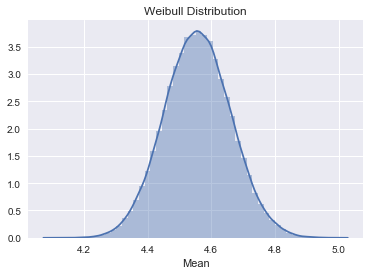

In [1]:
import random
import numba
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# The first "for" loop, sampling from a random distribution
@numba.jit
def MCHist(n, f, param1, param2):
    res = 0.0
    for _ in range(0, n):
        # Luckily, Python allows functions to be passed to other
        # functions as parameters, like a proper functional language.
        res += f(param1, param2)
    return res / float(n)

# The second "for" loop, repeated means of a set of samples
@numba.jit
def MCLoop(n_hist, n_samp, function, p1, p2):
    # For numba's sake, need to fill the list with the type
    # This will be negligible
    results = [4.5]
    for n in range(0, n_hist):
        results.append(MCHist(n_samp, function, p1, p2))
    return results

# User-defined parameters
alpha = 5 # Weibull scale parameter
beta = 1.4 # Weibull shape parameter 
num_samp = int(1e3) # First "for" loop
num_hist = int(1e5) # Second "for" loop

# Run the simulation
results = MCLoop(num_hist, num_samp, random.weibullvariate, alpha, beta)

# Plot the results    
f = sns.distplot(results)
f.set_xlabel('Mean')
f.set_title('Weibull Distribution');

As can be seen in the figure above, the distribution of the means of the sampling distribution looks approximately normal. But the Weibull distribution may sometimes look fairly similar to a normal distribution anyway. What if we choose a uniform distribution instead?

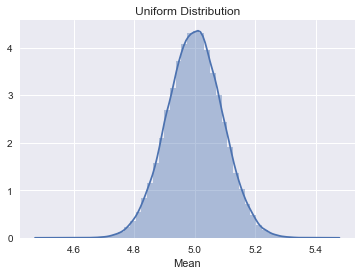

In [2]:
# User-defined parameters
a = 0 # Uniform distribution lower limit
b = 10 # Uniform distribution upper limit
num_samp2 = int(1e3) # First "for" loop
num_hist2 = int(1e5) # Second "for" loop

# Run the simulation
results2 = MCLoop(num_hist2, num_samp2, random.uniform, a, b)

# Plot the results    
f = sns.distplot(results2)
f.set_xlabel('Mean')
f.set_title('Uniform Distribution');

As seen above, the Central Limit Theorem works just as well with a uniform distribution as a Weibull distribution.

What about a discrete probability distribution? Let's use a probability distribution where we choose 1 20% of the time, 2 50% of the time, and 3 30% of the time. This will require us to modify our Monte Carlo function somewhat:

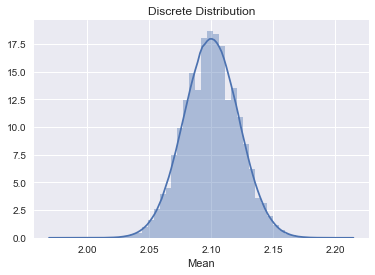

In [3]:
# p_a is the probability that option a is chosen,
# s_a is the result if a is chosen, and so on
@numba.jit
def MCHist2(n_hist, p_a, s_a, p_b, s_b, p_c, s_c):
    res = 0
    for _ in range(0, n_hist):
        x = random.random()
        # The probabilities are cumulative
        if x <= p_a:
            res += s_a
        elif x <= (p_a + p_b):
            res += s_b
        elif x <= (p_a + p_b + p_c):
            res += s_c
    return res / float(n_hist)

@numba.jit
def MCLoop2(n_hist, n_samp):
    # For numba's sake, need to fill the list with the type
    results = [2.0]
    for _ in range(0, n_hist):
        results.append(MCHist2(n_samp, 0.2, 1, 0.5, 2, 0.3, 3))
    return results

# User-defined parameters
# We need a few more samples to get the shape to look right
num_samples3 = int(1e3) # First "for" loop
num_hist3 = int(1e7) # Second "for" loop

# Run the simulation
results3 = MCLoop2(num_hist3, num_samples3)

# Plot the results    
f = sns.distplot(results3)
f.set_xlabel('Mean')
f.set_title('Discrete Distribution');

This may be an even more surprising result. We chose a very simple distribution which was not even continuous, and we still get a normal distribution of the sample means!

One last example. Let's use an initial distribution which is a linear combination of all three distributions that we tried: a Weibull, a uniform, and a discrete. Will the Central Limit Theorem still hold in this case?

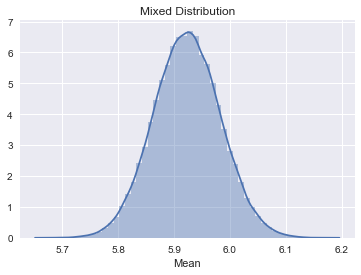

In [5]:
@numba.jit
def MCHist3(n_hist, alpha, beta, a, b, p_a, s_a, p_b, s_b, p_c, s_c):
    res = 0
    for _ in range(0, n_hist):
        val = 0
        # Weibull part
        val += random.weibullvariate(alpha, beta)
        # Uniform part
        val += random.uniform(a, b)
        # Discrete part
        x = random.random()
        if x <= p_a:
            val += s_a
        elif x <= (p_a + p_b):
            val += s_b
        elif x <= (p_a + p_b + p_c):
            val += s_c
        # Add the sum of all three distributions to the total results
        res += val
    return res / float(n_hist)

@numba.jit
def MCLoop3(n_hist, n_samp):
    # For numba's sake, need to fill the list with the type
    results = [6.0]
    for _ in range(0, n_hist):
        results.append(MCHist3(n_samp, 2, 1.4, 0, 4, 0.2, 1, 0.5, 2, 0.3, 3))
    return results

# User-defined parameters
num_samples4 = int(1e3) # First "for" loop
num_hist4 = int(1e5) # Second "for" loop

# Run the simulation
results4 = MCLoop3(num_hist4, num_samples4)

# Plot the results    
f = sns.distplot(results4)
f.set_xlabel('Mean')
f.set_title('Mixed Distribution');

As you might have expected by now, the Central Limit Theorem still holds, even if the initial distribution is a linear combination of several different distributions. 